In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI
from itertools import combinations
import time
import warnings
warnings.filterwarnings('ignore')

## we used those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

In [2]:
datadir = '../Datasets/'

In [3]:
def run_clustering(z, n=None, exclude=[], verbose=False):
    cluster_map = {}
    if 'ecg' not in exclude:
        starting_time = time.time()
        cluster_map['ecg'] = z.community_ecg().membership
        if verbose: print('ecg:', time.time() - starting_time)
    if 'louvain' not in exclude:
        starting_time = time.time()
        cluster_map['louvain'] = z.community_multilevel().membership
        if verbose: print('louvain:', time.time() - starting_time)
    if 'infomap' not in exclude:
        starting_time = time.time()
        cluster_map['infomap'] = z.community_infomap().membership
        if verbose: print('infomap:', time.time() - starting_time)
    if 'label_prog' not in exclude:
        starting_time = time.time()
        cluster_map['label_prog'] = z.community_label_propagation().membership
        if verbose: print('label_prog:', time.time() - starting_time)
    if 'gn' not in exclude:
        starting_time = time.time()
        cluster_map['gn'] = z.community_edge_betweenness().as_clustering(n).membership # Girvan-Newman
        if verbose: print('gn:', time.time() - starting_time)
    if 'cnm' not in exclude:
        starting_time = time.time()
        cluster_map['cnm'] = z.community_fastgreedy().as_clustering(n).membership
        if verbose: print('cnm:', time.time() - starting_time)
    return cluster_map

# Problem 1

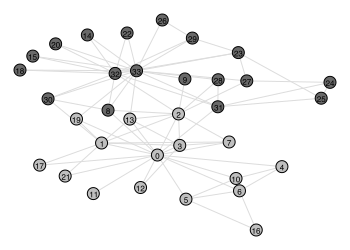

In [4]:
z = ig.Graph.Famous('zachary')
z.vs['size'] = 12
z.vs['name'] = [str(i) for i in range(z.vcount())]
z.vs['label'] = [str(i) for i in range(z.vcount())]
z.vs['label_size'] = 8
z.es['color'] = cls_edges
z.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
z.vs['color'] = [cls[i] for i in z.vs['comm']]
#ig.plot(z, 'zachary_gt.eps', bbox=(0,0,300,200))
ig.plot(z, bbox=(0,0,350,250))

In [5]:
print("---- AMI ----")
cluster_map = run_clustering(z, n=2)
ground_truth = z.vs['comm']
for cluster_method, cluster in cluster_map.items():
    ami = AMI(ground_truth, cluster)
    print(cluster_method, ':', round(ami, 4))

---- AMI ----
ecg : 0.6298
louvain : 0.5817
infomap : 0.6874
label_prog : 0.2015
gn : 0.8328
cnm : 0.8335


# Problem 2

In [6]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

lbl = ['web','ml']     ## node labels
## there are 2 node types: ml or web
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

In [7]:
## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


In [8]:
# running time
gh_ml_cluster_map = run_clustering(gh_ml, exclude=['gn'], verbose=True)

ecg: 1.5060999393463135
louvain: 0.06590485572814941
infomap: 10.23180103302002
label_prog: 0.05117392539978027
cnm: 0.22686290740966797


In [9]:
clustering_pairs = list(combinations(gh_ml_cluster_map.keys(), 2))
clustering_pairs_2_ami = {}
for pair in clustering_pairs:
    clutering_1 = gh_ml_cluster_map[pair[0]]
    clutering_2 = gh_ml_cluster_map[pair[1]]
    ami = round(AMI(clutering_1, clutering_2), 4)
    print(f'AMI of {pair[0]} and {pair[1]}:', ami)
    clustering_pairs_2_ami[pair] = ami

AMI of ecg and louvain: 0.6353
AMI of ecg and infomap: 0.5724
AMI of ecg and label_prog: 0.4941
AMI of ecg and cnm: 0.5478
AMI of louvain and infomap: 0.4996
AMI of louvain and label_prog: 0.5717
AMI of louvain and cnm: 0.5785
AMI of infomap and label_prog: 0.2973
AMI of infomap and cnm: 0.4686
AMI of label_prog and cnm: 0.5918


In [10]:
max_ami = max(clustering_pairs_2_ami, key=clustering_pairs_2_ami.get)
print(f'{max_ami[0]} and {max_ami[1]} produce the most similar result with ami = {clustering_pairs_2_ami[max_ami]}')

ecg and louvain produce the most similar result with ami = 0.6353


# Problem 5

In [9]:
## read graph and communities; plot
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1]-1 for x in g.vs]
gt = {k:(v-1) for k,v in enumerate(g.vs['comm'])}
# ## map between int(name) to key
# n2k = {int(v):k for k,v in enumerate(g.vs['name'])}
# g.vs['size'] = 7
# g.es['color'] = cls_edges
# g.vs['color'] = [cls[i] for i in g.vs['comm']]
# ig.plot(g, bbox=(0,0,300,200))

In [10]:
def compute_z_p(z):
    ## compute internal degrees
    n_comm = max(z.vs['comm'])
    in_deg_list = []
    for idx in range(n_comm+1):
        in_deg_i = z.subgraph_edges(
            [e for e in z.es if z.vs['comm'][e.tuple[0]]==idx and z.vs['comm'][e.tuple[1]]==idx],
            delete_vertices=False).degree()
        in_deg_list.append(in_deg_i)

    ## compute z (normalized within-module degree)
    vs_in_deg = []
    for i in range(z.vcount()): 
        vs_in_deg.append(sum([in_deg_i[i] for in_deg_i in in_deg_list]))
    z.vs['in_deg'] = vs_in_deg
    
    mu = []
    sig = []
    for in_deg in in_deg_list:
        mean = np.mean([x for x in in_deg if x>0])
        mu.append(mean)
        
        std = np.std([x for x in in_deg if x>0], ddof=1)
        sig.append(std)
    
    z.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in z.vs]

    ## computing p (participation coefficient)
    z.vs['deg'] = z.degree()
    z.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in z.vs]
    z.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in z.vs]
    D = pd.DataFrame(np.array([z.vs['z'],z.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
    return z, D

In [11]:
g, _ = compute_z_p(g)

In [12]:
## Zachary graph w.r.t. roles
# z.vs['color'] = 'black'
# z.vs['shape'] = 'circle'
families_count = {
    "non-hub": {
        "kinless": 0,
        "connector": 0,
        "peripheral": 0,
        "ultra-peripheral": 0
    },
    "hub": {
        "provincial": 0,
        "connector": 0,
        "kinless": 0
    }
}
for v in g.vs:
    if v['z'] <= 2.5: # non-hub
        if v['p'] >= .8: # kinless
            families_count["non-hub"]["kinless"] += 1 
        elif v['p'] >= .62 and v['p'] < .8: # connector
            families_count["non-hub"]["connector"] += 1
        elif v['p'] < .62 and v['p'] >= .05: # peripheral
            families_count["non-hub"]["peripheral"] += 1
        elif v['p'] < .05: # ultra-peripheral
            families_count["non-hub"]["ultra-peripheral"] += 1
    elif v['z'] > 2.5: # hub
        if v['p'] < .3: # provincial
            families_count["hub"]["provincial"] += 1
        elif v['p'] >= .3 and v['p'] < 0.75: # connector
            families_count["hub"]["connector"] += 1
        elif v['p'] >= .75: # kinless
            families_count["hub"]["kinless"] += 1
#ig.plot(z, 'zachary_roles_1.eps', bbox=(0,0,350,250))
# ig.plot(z, bbox=(0,0,350,250))
families_count

{'non-hub': {'kinless': 0,
  'connector': 0,
  'peripheral': 958,
  'ultra-peripheral': 0},
 'hub': {'provincial': 0, 'connector': 42, 'kinless': 0}}

In [13]:
for hub_type in families_count.keys():
    for family in families_count[hub_type].keys():
        print(f'{hub_type}/{family} contains {families_count[hub_type][family]} nodes')

non-hub/kinless contains 0 nodes
non-hub/connector contains 0 nodes
non-hub/peripheral contains 958 nodes
non-hub/ultra-peripheral contains 0 nodes
hub/provincial contains 0 nodes
hub/connector contains 42 nodes
hub/kinless contains 0 nodes


In [14]:
def plot_family_z_p(z):
    max_v_idx = len(z.vs()) - 1
    
    ## Figure 5.3(b) -- comparing the roles
    fig, ax = plt.subplots(figsize=(12,9))
    ax.scatter(z.vs['p'],z.vs['z'],marker='o',s=75, color='k')

    plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
    plt.plot([.05, .05], [-.5, 2.4], color='k', linestyle='-', linewidth=2)

    ax.annotate('node 0', (z.vs['p'][0],z.vs['z'][0]-.05), xytext=(z.vs['p'][0]+.01,z.vs['z'][0]-.3), 
                fontsize=14,
                arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

    ax.annotate(f'node {max_v_idx}', (z.vs['p'][max_v_idx],z.vs['z'][max_v_idx]-.05), xytext=(z.vs['p'][max_v_idx]-.07,z.vs['z'][max_v_idx]-.3), 
                fontsize=14,
                arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

    ax.annotate(f'node {max_v_idx-1}', (z.vs['p'][max_v_idx-1]-.005,z.vs['z'][max_v_idx-1]), xytext=(z.vs['p'][max_v_idx-1]-.07,z.vs['z'][max_v_idx-1]), 
                fontsize=14,
                arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

    ax.annotate('node 1', (z.vs['p'][1],z.vs['z'][1]-.05), xytext=(z.vs['p'][1]-.07,z.vs['z'][1]-.3), 
                fontsize=14,
                arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

    ax.annotate('node 3', (z.vs['p'][3],z.vs['z'][3]-.05), xytext=(z.vs['p'][3]+.07,z.vs['z'][3]-.3), 
                fontsize=14,
                arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

    ax.annotate('node 2', (z.vs['p'][2],z.vs['z'][2]-.05), xytext=(z.vs['p'][2]-.07,z.vs['z'][2]-.3), 
                fontsize=14,
                arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

    ax.annotate('provincial hubs',(.3,2.55), fontsize=18)
    ax.annotate('peripheral non-hubs',(.3,1.8), fontsize=18)
    ax.annotate('ultra peripheral non-hubs',(0.025,0.0),xytext=(.1,0), fontsize=18,
                 arrowprops = dict( arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))

    plt.xlabel('participation coefficient (p)',fontsize=16)
    plt.ylabel('normalized within module degree (z)',fontsize=16);
    #plt.savefig('zachary_roles_2.eps')

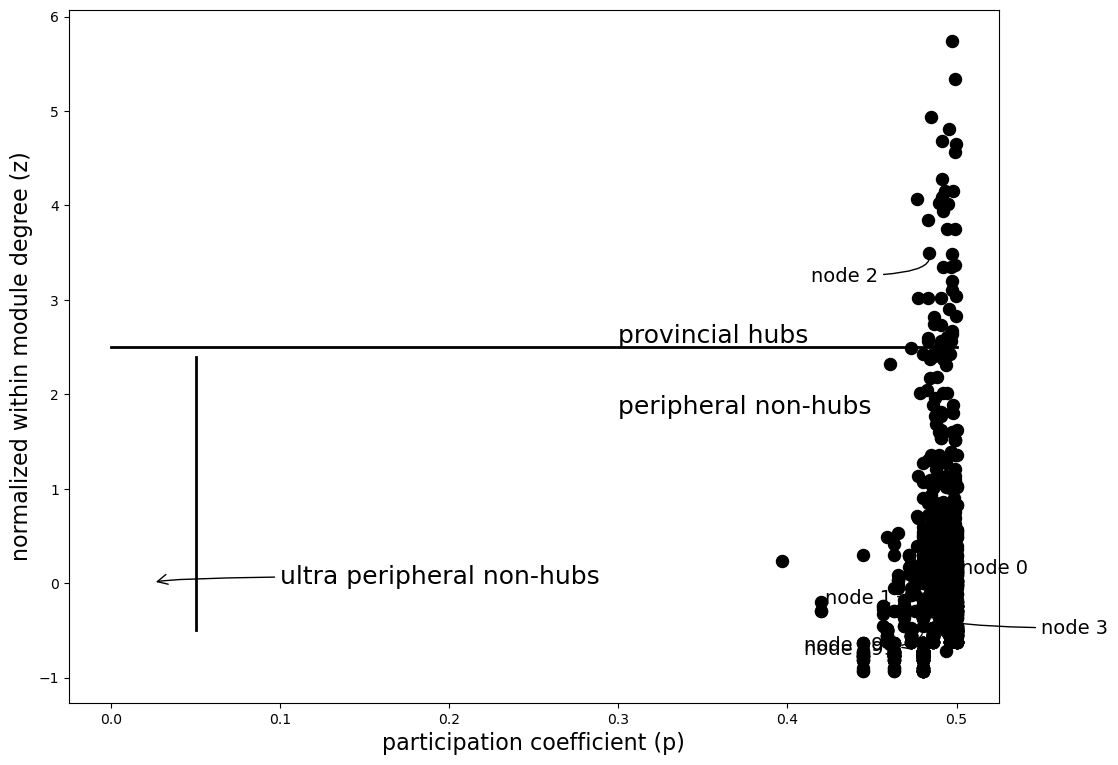

In [15]:
plot_family_z_p(g)

# Problem 6

In [6]:
abcd_path = '../Datasets/ABCDGraphGenerator.jl/utils/'
julia = '/Applications/Julia-1.8.app/Contents/Resources/julia/bin/julia'

In [26]:
L = {}   ## store results in a list
node_count_ls = [100, 200, 400, 800, 1600]
for node_count in node_count_ls:
    L[str(node_count)] = []
    
os.system(f"rm -r {' '.join([str(node_count) for node_count in node_count_ls])}")

REP = 1  ## number of graphs for each value of xi
# XIs = [x/100 for x in np.arange(10,81,5)] ## values for xi
XIs = [0.3]
print(f"XIs {XIs}")
for node_count in node_count_ls:
    print(f"============ node_count {node_count} ============")
    
    os.system(f"mkdir {str(node_count)}")

    for rep in range(REP):
        deg_path = f'{node_count}/deg.dat'
        cmd = f'{julia} {abcd_path}/deg_sampler.jl {deg_path} 2.5 10 50 {node_count} 1000'
        os.system(cmd)

        cs_path = f'{node_count}/cs.dat'
        cmd = f'{julia} {abcd_path}/com_sampler.jl {cs_path} 1.5 50 100 {node_count} 1000'
        os.system(cmd)

        for xi in XIs:
            print(f"------------- xi {xi} -------------")
            net_path = f'{node_count}/net.dat'
            comm_path = f'{node_count}/comm.dat'
            cmd = f'{julia} {abcd_path}/graph_sampler.jl {net_path} {comm_path} {deg_path} {cs_path} xi {str(xi)} false false'
            os.system(cmd)
            
            ## compute AMI for various clustering algorithms
            g = ig.Graph.Read_Ncol(net_path, directed=False)
            c = np.loadtxt(comm_path, dtype='uint16', usecols=(1))
            g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]
            n = max(g.vs['comm'])
            
            cluster_func_dict = {
                'ecg': g.community_ecg,
                'louvain': g.community_multilevel,
                'infomap': g.community_infomap,
                'label_prog': g.community_label_propagation,
                'gn': g.community_edge_betweenness,
                'cnm': g.community_fastgreedy,
            }
            for cluster_name, cluster_func in cluster_func_dict.items():
                start = time.time()
                if cluster_name in ['gn', 'cnm']:
                    _ = cluster_func().as_clustering(n)
                else:
                    _ = cluster_func()
                end = time.time()
                elapsed_time = end - start
                print(cluster_name, elapsed_time)
                L[str(node_count)].append(elapsed_time)

rm: 1600: No such file or directory


XIs [0.3]
============ node_count 100 ============


[ Info: Usage: julia deg_sampler.jl filename τ₁ d_min d_max n max_iter [seed]
[ Info: Example: julia deg_sampler.jl degrees.dat 3 5 50 10000 1000 42
[ Info: Expected value of degree: 17.59492981753638
[ Info: Usage: julia com_sampler.jl filename τ₂ c_min c_max n max_iter [seed] [nout]
[ Info: Example: julia com_sampler.jl community_sizes.dat 2 50 1000 10000 1000 42 100
[ Info: Expected value of community size: 70.53394879444838


------------- xi 0.3 -------------


[ Info: Usage: julia graph_sampler.jl networkfile communityfile degreefile communitysizesfile mu|xi fraction isCL islocal [seed] [nout]
[ Info: Example: julia graph_sampler.jl network.dat community.dat degrees.dat community_sizes.dat xi 0.2 true true 42 100


ecg 0.023712873458862305
louvain 0.0007081031799316406
infomap 0.007651805877685547
label_prog 0.0001862049102783203
gn 0.4130129814147949
cnm 0.0005700588226318359
============ node_count 200 ============


[ Info: Usage: julia deg_sampler.jl filename τ₁ d_min d_max n max_iter [seed]
[ Info: Example: julia deg_sampler.jl degrees.dat 3 5 50 10000 1000 42
[ Info: Expected value of degree: 17.59492981753638
[ Info: Usage: julia com_sampler.jl filename τ₂ c_min c_max n max_iter [seed] [nout]
[ Info: Example: julia com_sampler.jl community_sizes.dat 2 50 1000 10000 1000 42 100
[ Info: Expected value of community size: 70.53394879444838


------------- xi 0.3 -------------


[ Info: Usage: julia graph_sampler.jl networkfile communityfile degreefile communitysizesfile mu|xi fraction isCL islocal [seed] [nout]
[ Info: Example: julia graph_sampler.jl network.dat community.dat degrees.dat community_sizes.dat xi 0.2 true true 42 100


ecg 0.041539907455444336
louvain 0.0010361671447753906
infomap 0.017045021057128906
label_prog 0.0004470348358154297
gn 3.044651985168457
cnm 0.0018796920776367188
============ node_count 400 ============


[ Info: Usage: julia deg_sampler.jl filename τ₁ d_min d_max n max_iter [seed]
[ Info: Example: julia deg_sampler.jl degrees.dat 3 5 50 10000 1000 42
[ Info: Expected value of degree: 17.59492981753638
[ Info: Usage: julia com_sampler.jl filename τ₂ c_min c_max n max_iter [seed] [nout]
[ Info: Example: julia com_sampler.jl community_sizes.dat 2 50 1000 10000 1000 42 100
[ Info: Expected value of community size: 70.53394879444838


------------- xi 0.3 -------------


[ Info: Usage: julia graph_sampler.jl networkfile communityfile degreefile communitysizesfile mu|xi fraction isCL islocal [seed] [nout]
[ Info: Example: julia graph_sampler.jl network.dat community.dat degrees.dat community_sizes.dat xi 0.2 true true 42 100


ecg 0.08267903327941895
louvain 0.0026967525482177734
infomap 0.04370403289794922
label_prog 0.0011179447174072266
gn 21.39252996444702
cnm 0.004858255386352539
============ node_count 800 ============


[ Info: Usage: julia deg_sampler.jl filename τ₁ d_min d_max n max_iter [seed]
[ Info: Example: julia deg_sampler.jl degrees.dat 3 5 50 10000 1000 42
[ Info: Expected value of degree: 17.59492981753638
[ Info: Usage: julia com_sampler.jl filename τ₂ c_min c_max n max_iter [seed] [nout]
[ Info: Example: julia com_sampler.jl community_sizes.dat 2 50 1000 10000 1000 42 100
[ Info: Expected value of community size: 70.53394879444838


------------- xi 0.3 -------------


[ Info: Usage: julia graph_sampler.jl networkfile communityfile degreefile communitysizesfile mu|xi fraction isCL islocal [seed] [nout]
[ Info: Example: julia graph_sampler.jl network.dat community.dat degrees.dat community_sizes.dat xi 0.2 true true 42 100


ecg 0.1733090877532959
louvain 0.0036208629608154297
infomap 0.09715628623962402
label_prog 0.001580953598022461
gn 158.2232587337494
cnm 0.015326976776123047
============ node_count 1600 ============


[ Info: Usage: julia deg_sampler.jl filename τ₁ d_min d_max n max_iter [seed]
[ Info: Example: julia deg_sampler.jl degrees.dat 3 5 50 10000 1000 42
[ Info: Expected value of degree: 17.59492981753638
[ Info: Usage: julia com_sampler.jl filename τ₂ c_min c_max n max_iter [seed] [nout]
[ Info: Example: julia com_sampler.jl community_sizes.dat 2 50 1000 10000 1000 42 100
[ Info: Expected value of community size: 70.53394879444838


------------- xi 0.3 -------------


[ Info: Usage: julia graph_sampler.jl networkfile communityfile degreefile communitysizesfile mu|xi fraction isCL islocal [seed] [nout]
[ Info: Example: julia graph_sampler.jl network.dat community.dat degrees.dat community_sizes.dat xi 0.2 true true 42 100


ecg 0.3766138553619385
louvain 0.008880138397216797
infomap 0.21748709678649902
label_prog 0.003287076950073242
gn 1373.812355041504
cnm 0.05546379089355469


In [27]:
cluster_running_time = pd.DataFrame(data=L)
# cluster_running_time['cluster_method'] = cluster_func_dict.keys()
cluster_running_time = cluster_running_time.T
cluster_running_time.columns = cluster_func_dict.keys()
cluster_running_time

,ecg,louvain,infomap,label_prog,gn,cnm
100,0.023713,0.000708,0.007652,0.000186,0.413013,0.000570
200,0.041540,0.001036,0.017045,0.000447,3.044652,0.001880
400,0.082679,0.002697,0.043704,0.001118,21.392530,0.004858
800,0.173309,0.003621,0.097156,0.001581,158.223259,0.015327
1600,0.376614,0.008880,0.217487,0.003287,1373.812355,0.055464


In [28]:
cluster_method_2_time = dict(cluster_running_time.mean())

In [29]:
fastest_method = min(cluster_method_2_time, key=cluster_method_2_time.get)
slowest_method = max(cluster_method_2_time, key=cluster_method_2_time.get)
print(f'{fastest_method} is fastest with {cluster_method_2_time[fastest_method]} seconds')
print(f'{slowest_method} is slowest with {cluster_method_2_time[slowest_method]} seconds')

label_prog is fastest with 0.001323843002319336 seconds
gn is slowest with 311.3771617412567 seconds
